<h1>Data Science: Final Project</h1>

In [ ]:
import aiohttp
import asyncio
from catboost import CatBoostRegressor
from datetime import datetime
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd
import re
import requests
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import sqlite3

Цель данного проекта - анализ данных о крупнейшем еженедельном турнире для титулованных шахматистов под названием Titled Tuesday, который проводится сайтом chess.com. В ходе работы над проектом применяются многие навыки, обретенные по мере изучения курса: обработка и визуализация данных, работа с геоданными графами, машинное обучение и т.д.

<h2>Получение данных. Веб-скреппинг</h2>

С помощью скрэппинга (используем Selenium) получим данные о лучших 25 игроках в последних 250 турнирах Titled Tuesday, охватывающих период с 12.2021 по 06.2024 (не рекомендуется к повторению в домашних условиях - результат работы уже доступен в качестве .csv-файла). 

In [2]:
driver = webdriver.Chrome()

link = 'https://www.schoolschoolschool.com/tournament/live/titled-tuesdays' #оригинально обходим блокировку
driver.get(link)

x_button = driver.find_element(By.CLASS_NAME, 'icon-font-chess.x.outside-close-icon')
x_button.click()

In [3]:
tournaments = []
for i in range(1, 11):
    links = driver.find_elements(By.CLASS_NAME, 'tournaments-live-name ')
    links = [elem.get_attribute('href') for elem in links]
    tournaments.extend(links)
    driver.get(link + f'?&page={i+1}')

In [4]:
def get_result(text):
    res = [0, '']
    if text[0] in '01':
        res[0] = int(text[0])
    else:
        res[0] = 0.5
    res[1] = text[-1]
    return res

In [5]:
df = pd.DataFrame()

Среди данных необходимо выделить те, которые идентифицируют каждую конкретную игру и ее участников: никнеймы и рейтинги последних, страны, которые они представляют, цвет фигур, дату результат игры, а также результат всего турнира для игрока:

In [9]:
for elem in tournaments[:243]: #отдельно для 243:245 и 245: - разные форматы для даты
    driver.get(elem)
    results = driver.find_element(By.XPATH, '//table').find_element(By.TAG_NAME, 'tbody').find_elements(By.TAG_NAME, 'tr')
    #date
    date = driver.find_element(By.XPATH, '//h1[contains(@class, "v5-title-label")]').text
    date = date.split('-')
    date = '-'.join(date[-3:] + [date[0]]) #for [243:245]: date = '-'.join(date[-4:-1] + [['Late', 'Early'][date[-1] == 'A']]) , for [245:]: date = '-'.join(date[-3:])
    #nicknames
    nicknames = [i.find_element(By.CLASS_NAME, 'user-username-component.user-username-blue-with-dark-mode.user-tagline-username') for i in results]
    nicknames = [i.get_attribute('text') for i in nicknames]
    nicknames = [i.strip('\n, ') for i in nicknames]
    #titles
    titles = [i.text for i in driver.find_elements(By.XPATH, '//a[contains(@class, "post-view-meta-title")]')][3:28]
    #countries
    countries = driver.find_elements(By.XPATH, '(//div)[contains(@class, "country-flags-component")] | (//a)[contains(@class, "country-flags-component")]')
    countries = [i.get_attribute('v-tooltip') for i in countries]
    countries = [i if 'Click here to see our stance on the war in Ukraine' not in i else 'FIDE' for i in countries][3:28]
    #ratings
    ratings = driver.find_elements(By.XPATH, '//span[contains(@class, "user-rating")]')[:25]
    ratings = [int(i.text.strip('()')) if i.text.strip('()').isnumeric() else i.text.strip('()') for i in ratings]
    #game results
    games = driver.find_elements(By.XPATH, '//a[contains(@class,"tournaments-live-view-player-result v5-link")]')
    games = [games[i:(i+11)] for i in range(0,len(games),11)]
    games = [[i.text for i in item] for item in games]
    games = [[get_result(i) for i in item] for item in games]
    #opponent
    opponents = driver.find_elements(By.XPATH, '//a[contains(@class,"tournaments-live-view-player-result v5-link")]')
    opponents = [opponents[i:(i+11)] for i in range(0,len(opponents),11)]
    opponents = [[i.get_attribute('v-tooltip').strip() for i in item] for item in opponents]
    opponents = [[re.sub('\(.*?\)', '', i) for i in item] for item in opponents]
    for name, log in zip(nicknames, opponents):
        for i in range(len(log)):
            log[i] = re.sub(name, '', log[i])
            log[i] = re.sub('vs', '', log[i])
            log[i] = log[i].strip()
    #total scores
    total_scores = [sum([i[0] for i in item]) for item in games]
    #tie breaks
    tie_breaks = driver.find_elements(By.XPATH, '//td[contains(@class,"tournaments-live-view-tie-break")]')
    tie_breaks = [float(i.text) for i in tie_breaks]
    df_list = []
    for name, title, country, rating, game, opponent, total, tie_break in zip(nicknames, titles, countries, ratings,
                                                                    games, opponents, total_scores, tie_breaks):
        if len(game) == 11 and len(opponent) == 11:
            temp_df = pd.DataFrame({'date' : [date] * 11,
                           'player' : [name] * 11,
                            'title' : [title] * 11,
                           'country' : [country] * 11,
                           'rating' : [rating] * 11,
                           'pieces_color' : [i[1] for i in game],
                           'game_result' : [i[0] for i in game],
                           'opponent' : opponent,
                           'total_score' : [total] * 11,
                           'tie_break' : [tie_break] * 11}
                          )
            df_list.append(temp_df)
    total_df = pd.concat(df_list)
    df = pd.concat([total_df, df])


<>:30: SyntaxWarning: invalid escape sequence '\('
<>:30: SyntaxWarning: invalid escape sequence '\('
C:\Users\Cornflip\AppData\Local\Temp\ipykernel_7796\2197643107.py:30: SyntaxWarning: invalid escape sequence '\('
  opponents = [[re.sub('\(.*?\)', '', i) for i in item] for item in opponents]


<h2>Обработка данных и визуализация</h2>

Результатом сбора данных стал датафрейм следующего содержания:

In [3]:
df

date     player title     country rating pieces_color  \
0    December-28-2021  GGuseinov    GM  Azerbaijan   2874            b   
1    December-28-2021  GGuseinov    GM  Azerbaijan   2874            w   
2    December-28-2021  GGuseinov    GM  Azerbaijan   2874            b   
3    December-28-2021  GGuseinov    GM  Azerbaijan   2874            w   
4    December-28-2021  GGuseinov    GM  Azerbaijan   2874            w   
..                ...        ...   ...         ...    ...          ...   
6   June-04-2024-Late     Hikaru    GM     Morocco   3175            w   
7   June-04-2024-Late     Hikaru    GM     Morocco   3175            b   
8   June-04-2024-Late     Hikaru    GM     Morocco   3175            w   
9   June-04-2024-Late     Hikaru    GM     Morocco   3175            b   
10  June-04-2024-Late     Hikaru    GM     Morocco   3175            b   

    game_result               opponent  total_score  tie_break  
0           1.0                Pakarma          9.5       65.0  
1           1.0            harlem4brew          9.5       65.0  
2           1.0                 Niktlt          9.5       65.0  
3           1.0       Gabrielian_Artur          9.5       65.0  
4           1.0         hanzo_hasashi1          9.5       65.0  
..          ...                    ...          ...        ...  
6           1.0            rasmussvane          8.0       66.0  
7           0.0             BogdanDeac          8.0       66.0  
8           0.5             Onischuk_V          8.0       66.0  
9           1.0          Aygehovit1992          8.0       66.0  
10          1.0  ExchangeAB     dretch          8.0       66.0  

[67716 rows x 10 columns]

Сохрании его в формате .csv, дабы не повторять длительную процедуру сбора данных.

In [79]:
df.to_csv('output.csv')

In [2]:
df = pd.read_csv('output.csv', index_col=0)

C:\Users\Cornflip\AppData\Local\Temp\ipykernel_1144\2353537236.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('output.csv', index_col=0)


In [3]:
df.index = np.arange(len(df))
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

Посмотрим на некоторые сводные данные при помощи графиков. Например, ниже представлена гистограмма, изображающая количество результатов игр, сыгранных белыми или черными фигурами:

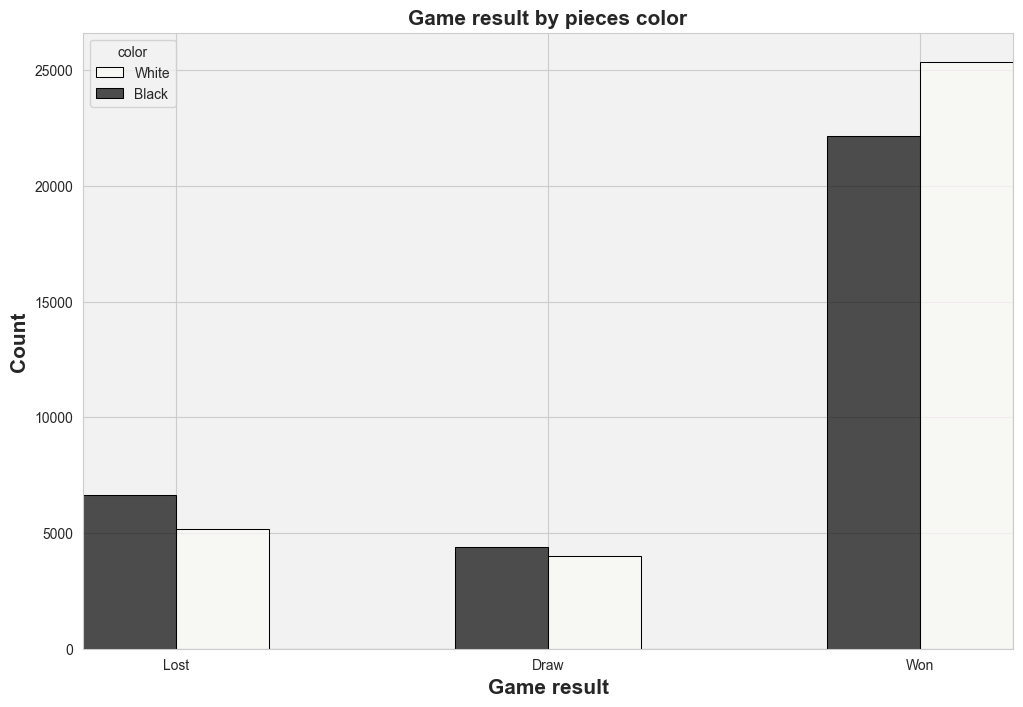

In [5]:
sns.set_style("whitegrid", {"axes.facecolor": ".95"})
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

sns.histplot(df, x='game_result', hue='pieces_color',
             multiple='dodge', binwidth=0.2, 
             palette=['#141414', '#FAF9F6'], 
             edgecolor = 'black', linewidth = .75)
plt.legend(title='color', loc='upper left', labels=['White', 'Black'])
ax.set_title('Game result by pieces color', fontsize=15, weight='bold')
ax.set_xlabel('Game result', fontsize=15, weight='bold')
ax.set_ylabel('Count', fontsize=15, weight='bold')
ax.set_xlim(0,1)
ax.set_xticks([0.1,0.5,0.9])
ax.set_xticklabels(['Lost', 'Draw', 'Won'])
plt.show()

Можно заметить, что правило "белые начинают и выигрывают" в целом соблюдается - хотя бы для лучших шахматистов мира.

Теперь посмотрим на так называемый ящик с усами с данными о зависимости итогов турнира для игроков и их рейтинга на сайте: 

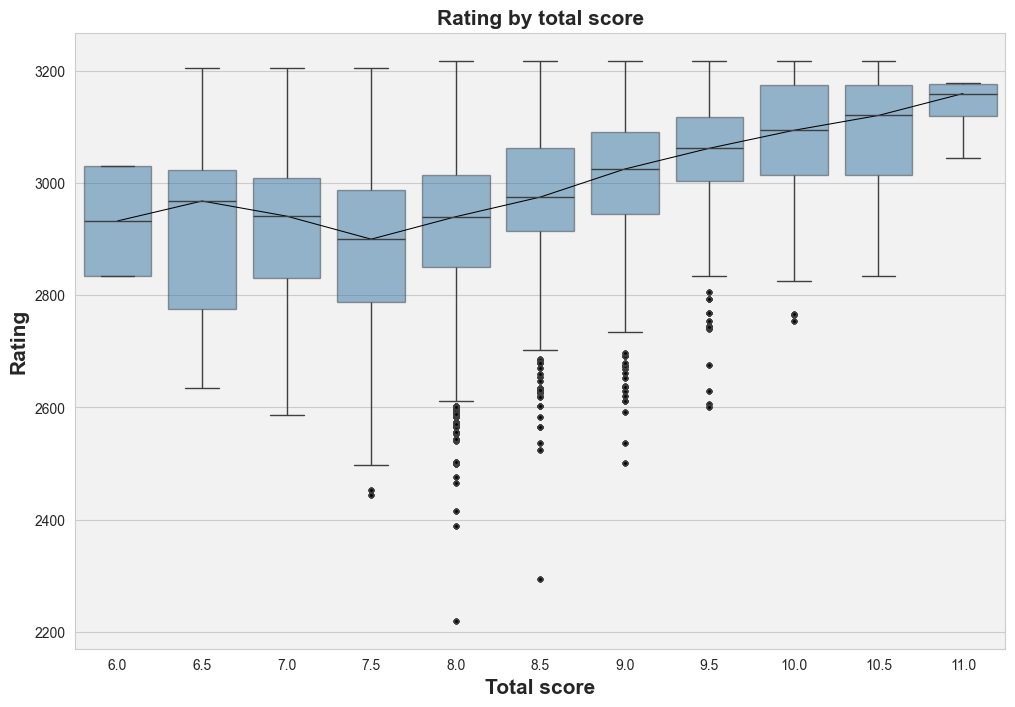

In [6]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sns.boxplot(df, x='total_score', y='rating', boxprops={'alpha':.5},
            flierprops={'marker': '.', 'markerfacecolor': 'black'})
sns.pointplot(df.groupby('total_score').agg({'rating':'median'}), 
              x='total_score', y='rating', ax=ax, color='black',
              marker="_", markersize=47, linewidth=.75)
ax.set_title('Rating by total score', fontsize=15, weight='bold')
ax.set_xlabel('Total score', fontsize=15, weight='bold')
ax.set_ylabel('Rating', fontsize=15, weight='bold')
plt.show()

И снова наблюдаем в целом ожидаемые результаты: чем сильнее игрок относительно своих оппонентов, тем лучше он выступает в турнирах с их участием. Обратим внимание на то, что хотя существует группа относительно сильных игроков, попадающих в топ с довольно слабыми результатами (от 6 до 7 очков из 11), она довольно немногочисленна.

Посмотрим на еще одну фичу сайта - отображение званий шахматистов (например, если кто-то из них является гроссмейстером, соответствующий символ будет сопровождать ник игрока). Сгруппируем данные о рейтинге на сайте для игроков разных званий и оценим результат:

In [7]:
avg_scores = df.groupby('title').agg({'rating': 'mean'})

In [8]:
avg_scores.sort_values('rating', ascending=False)

rating
title             
GM     2990.427639
IM     2861.928358
FM     2794.720930
CM     2783.810811
NM     2761.388889
WIM    2655.500000
WGM    2639.000000
WFM    2295.000000

Ожидаемо гроссмейстеры с большим отрывом оказываются сильнейшей когортой шахматистов, однако нам все еще не ясно, как распределяются звания в зависимости от рейтинга. Эту проблему нам позволит решить еще один график:

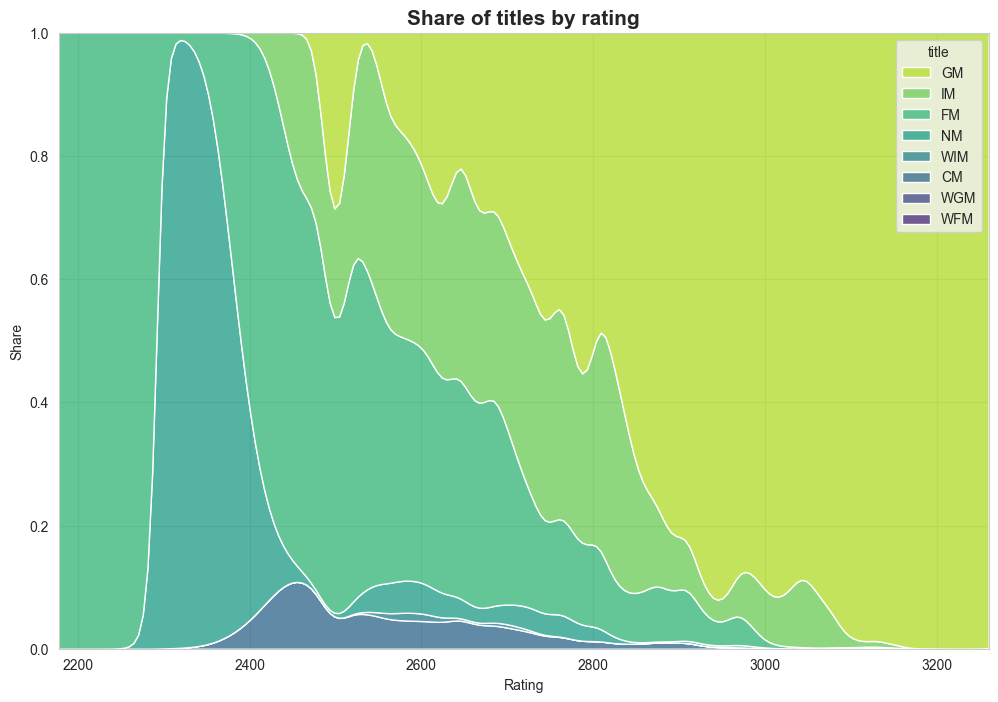

In [10]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sns.kdeplot(df, x='rating', hue='title', multiple='fill', palette='viridis_r', warn_singular=False)
ax.set_title('Share of titles by rating', fontsize=15, weight='bold')
ax.set_xlabel('Rating')
ax.set_ylabel('Share')
plt.show()

Результат распределен по-разному: для мастеров ФИДЕ, которых в мире несколько тысч человек, они распределены без явных пиков, а о шахматисках со специально выделенными женскими титулами данных совсем немного и поэтому распределены гораздо менее "равномерно".

Теперь посмотрим на то, участники из каких стран лучше всего проявляют себя в турнирах и имеют самый высокий рейтинг. Для этого рассмотрим средние значения соотвествующих показателей для участников из стран, которые представляют как минимум 1% от всех участников.

In [11]:
country_df = df.groupby('country').agg({'total_score' : 'mean', 
                                        'rating' : 'mean', 
                                        'tie_break': 'mean', 
                                        'player' : 'nunique'}).reset_index().sort_values(by='country')
country_df = country_df.rename(columns={'player': 'players_no'})
country_df = country_df[country_df.players_no >= country_df.players_no.sum() // 100] # >= 6
country_df = country_df.sort_values('players_no', ascending=False)
country_df.head(10)

country  total_score       rating  tie_break  players_no
85  United States     8.446067  3006.552306  61.093539          93
25           FIDE     8.385850  2953.755054  59.492271          90
35          India     8.378641  2959.135922  59.874595          41
60         Poland     8.350962  2903.872549  60.562500          41
82        Ukraine     8.257042  2845.584507  61.110915          33
73          Spain     8.159274  2914.991935  59.529234          28
37  International     8.271967  2887.054393  58.420502          27
1         Armenia     8.412651  2941.403614  61.251506          21
4      Azerbaijan     8.360465  2941.263566  61.282946          19
67         Serbia     8.418410  3007.602510  60.238494          19

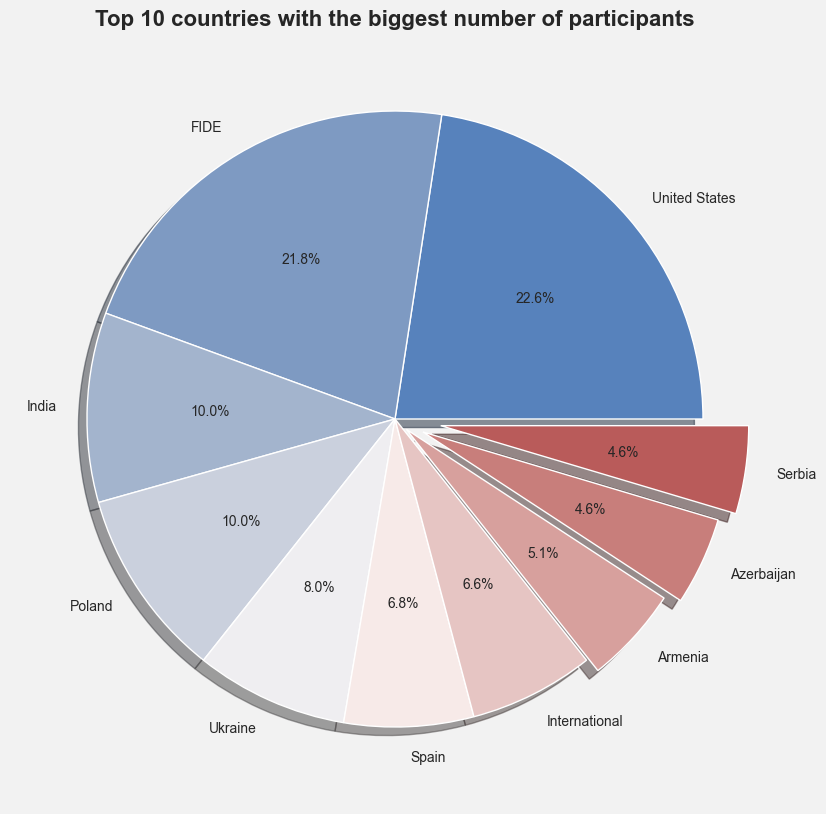

In [12]:
plt.figure(figsize=(10, 10), facecolor='.95')
ax = fig.add_subplot(111)

color = sns.color_palette('vlag', 10)
explode = [0] * 7 + [.05, .1, .15]
plt.pie(country_df['players_no'][:10], labels=country_df['country'][:10], 
        colors=color, autopct='%.1f%%', explode=explode, shadow=True)
plt.title('Top 10 countries with the biggest number of participants', fontsize=16, weight='bold')
plt.show()

Многие лучшие игроки представляют страны с большим населением (США, Индия и др.). Заметно и широкое присутствие стран бывшего СССР, что говорит о силе советских шахматных традиций, не ослабевающей спустя три десятилетия.

Посмотрим теперь на игроков, представляющих свои страны лучше всего. Отберем страны с достаточно большим числом участников и сравним их по среднему рейтингу, числу участников, среднему результату в турнире:

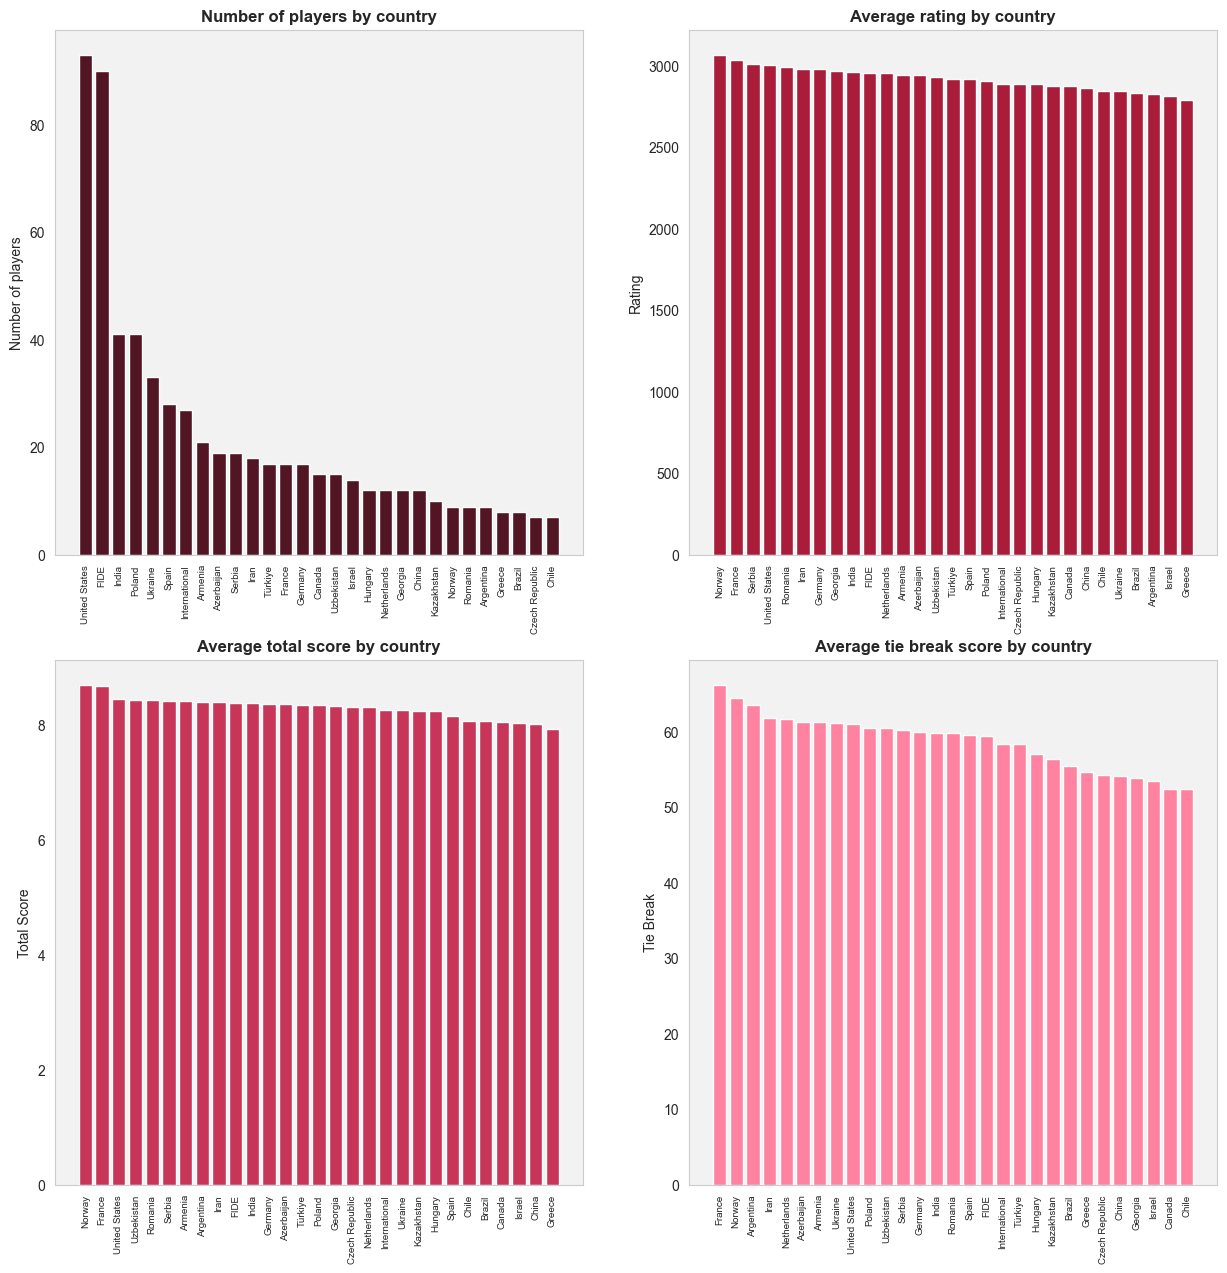

In [13]:
gs = gridspec.GridSpec(2,2)
colors = ['#511523', '#A91D3A', '#C73659', '#ff82a0']
fig = plt.figure(figsize=(15,15))

country_df = country_df.sort_values('players_no', ascending=False)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor('.95')
ax1.bar(country_df.country, country_df.players_no, color=colors[0])
ax1.set_xticks(np.arange(0, len(country_df)), list(country_df.country), rotation=90, fontsize=7)
ax1.set_title('Number of players by country', weight='bold')
ax1.set_ylabel('Number of players')
ax1.grid(False)

country_df = country_df.sort_values('rating', ascending=False)
ax2 = fig.add_subplot(gs[0, 1]) 
ax2.set_facecolor('.95')
ax2.bar(country_df.country, country_df.rating, color=colors[1])
ax2.set_xticks(np.arange(0, len(country_df)), list(country_df.country), rotation=90, fontsize=7)
ax2.set_title('Average rating by country', weight='bold')
ax2.set_ylabel('Rating')
ax2.grid(False)

country_df = country_df.sort_values('total_score', ascending=False)
ax3 = fig.add_subplot(gs[1, 0]) 
ax3.set_facecolor('.95')
ax3.bar(country_df.country, country_df.total_score, color=colors[2])
ax3.set_xticks(np.arange(0, len(country_df)), list(country_df.country), rotation=90, fontsize=7)
ax3.set_title('Average total score by country', weight='bold')
ax3.set_ylabel('Total Score')
ax3.grid(False)

country_df = country_df.sort_values('tie_break', ascending=False)
ax4 = fig.add_subplot(gs[1, 1]) 
ax4.set_facecolor('.95')
ax4.bar(country_df.country, country_df.tie_break, color=colors[3])
ax4.set_xticks(np.arange(0, len(country_df)), list(country_df.country), rotation=90, fontsize=7)
ax4.set_title('Average tie break score by country', weight='bold')
ax4.set_ylabel('Tie Break')
ax4.grid(False)


plt.show()

<h2>Работа с геоданными</h2>

Для наглядности нанесем эти же данные на карту мира с помощью <b>geopandas</b>

In [14]:
world = gpd.read_file('custom.geo.json')

In [15]:
world = world.loc[:, ['admin', 'geometry']].rename(columns={'admin' : 'country'})
world.index = world.country

In [16]:
world.loc['United States of America', 'country'] = 'United States'
fide = gpd.GeoSeries([world.loc['Russia', 'geometry'], world.loc['Belarus', 'geometry']])
world.loc['FIDE', 'geometry'] = fide.unary_union
world.loc['FIDE', 'country'] = 'FIDE'
world.index = np.arange(0, world.shape[0])

In [17]:
world = world.merge(country_df, on='country', how='left')
world = world.fillna(0)
world.head()

country                                           geometry  \
0          Costa Rica  POLYGON ((-82.54620 9.56613, -82.93289 9.47681...   
1           Nicaragua  POLYGON ((-83.65561 10.93876, -83.89505 10.726...   
2               Haiti  POLYGON ((-71.71236 19.71446, -71.62487 19.169...   
3  Dominican Republic  POLYGON ((-71.70830 18.04500, -71.68774 18.316...   
4         El Salvador  POLYGON ((-89.35333 14.42413, -89.05851 14.340...   

   total_score  rating  tie_break  players_no  
0          0.0     0.0        0.0         0.0  
1          0.0     0.0        0.0         0.0  
2          0.0     0.0        0.0         0.0  
3          0.0     0.0        0.0         0.0  
4          0.0     0.0        0.0         0.0

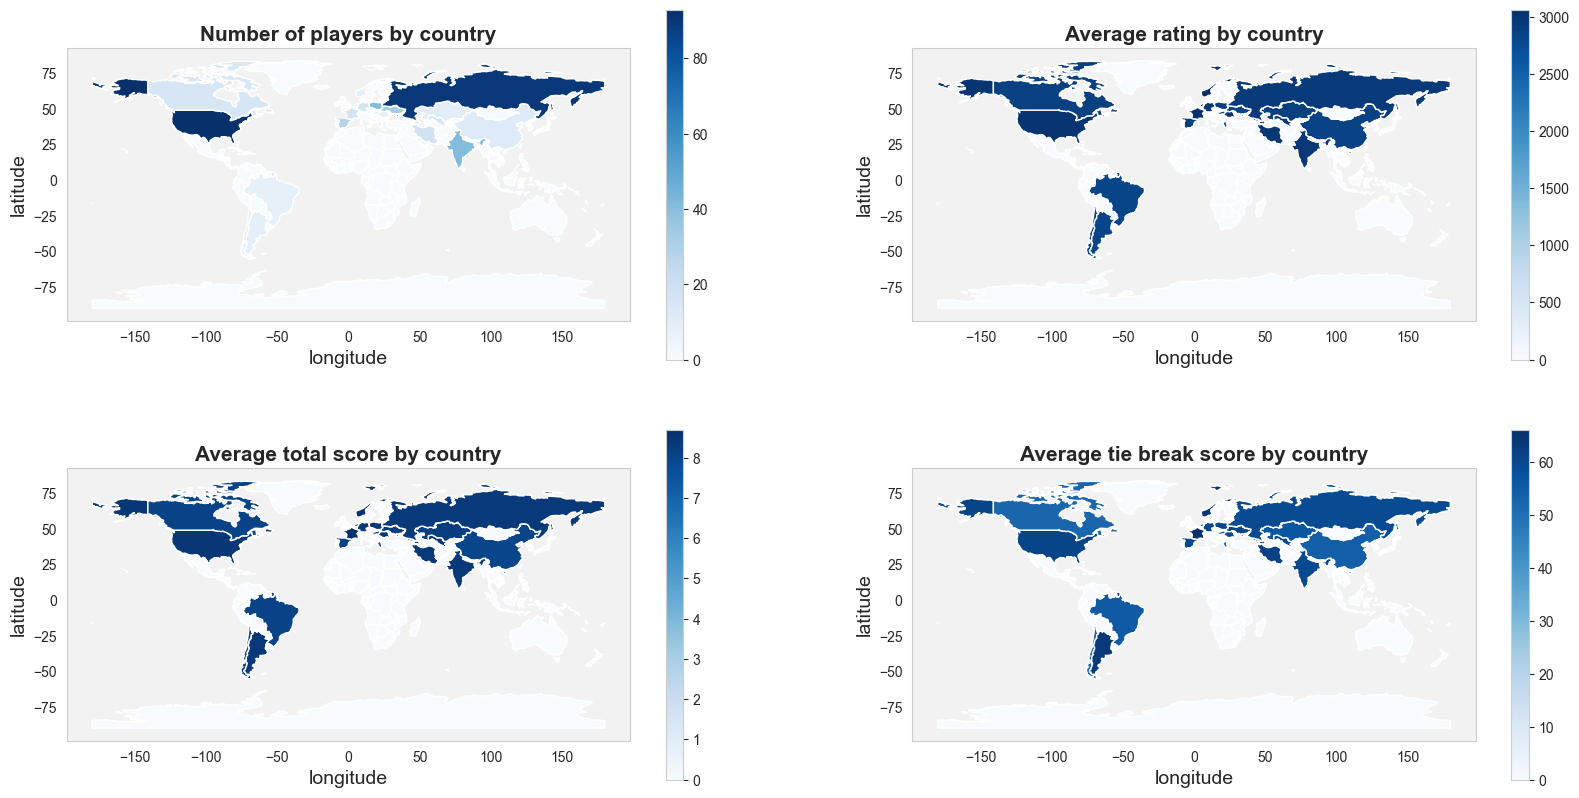

In [18]:
gs = gridspec.GridSpec(2,2)
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_xlabel('longitude', fontsize = 14)
ax1.set_ylabel('latitude', fontsize = 14)
ax1.set_title('Number of players by country', fontsize = 15, weight='bold')
ax1.grid(False)
world.plot('players_no', ax=ax1, cmap="Blues", legend=True)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_xlabel('longitude', fontsize = 14)
ax2.set_ylabel('latitude', fontsize = 14)
ax2.set_title('Average rating by country', fontsize = 15, weight='bold')
ax2.grid(False)
world.plot('rating', ax=ax2, cmap="Blues", legend=True)

ax3 = fig.add_subplot(gs[1, 0])
ax3.set_xlabel('longitude', fontsize = 14)
ax3.set_ylabel('latitude', fontsize = 14)
ax3.set_title('Average total score by country', fontsize = 15, weight='bold')
ax3.grid(False)
world.plot('total_score', ax=ax3, cmap="Blues", legend=True)

ax4 = fig.add_subplot(gs[1, 1])
ax4.set_xlabel('longitude', fontsize = 14)
ax4.set_ylabel('latitude', fontsize = 14)
ax4.set_title('Average tie break score by country', fontsize = 15, weight='bold')
ax4.grid(False)
world.plot('tie_break', ax=ax4, cmap="Blues", legend=True)
plt.show()

<h2><i>Данные о лучших игроках: обработка/визуализация</i></h2>

Теперь посмотрим на лучших игроков по отдельности. Как часто они попадают в топ-25, и если попадают, то сколько очков набирают?

In [19]:
players_df = pd.pivot_table(df, index='player', columns='total_score', aggfunc={'country':'count'})
players_df = pd.DataFrame(players_df['country'])
players_df = players_df / 11
players_df = players_df.fillna(0)
players_df['total_entries'] = players_df.sum(axis=1)
players_df = players_df[players_df.total_entries >= 50]
players_df = players_df.sort_values('total_entries', ascending=False)
players_df.head()

total_score           6.0  6.5  7.0  7.5   8.0   8.5   9.0   9.5  10.0  10.5  \
player                                                                         
FairChess_on_YouTube  0.0  0.0  1.0  4.0  55.0  30.0  54.0  19.0   7.0   1.0   
Hikaru                0.0  0.0  1.0  1.0  13.0  30.0  39.0  49.0  25.0   5.0   
Oleksandr_Bortnyk     0.0  1.0  1.0  5.0  44.0  43.0  46.0  12.0   2.0   0.0   
Jospem                0.0  0.0  1.0  9.0  36.0  40.0  40.0  19.0   4.0   1.0   
mishanick             0.0  0.0  3.0  9.0  34.0  43.0  36.0  12.0   6.0   0.0   

total_score           11.0  total_entries  
player                                     
FairChess_on_YouTube   0.0          171.0  
Hikaru                 1.0          164.0  
Oleksandr_Bortnyk      0.0          154.0  
Jospem                 1.0          151.0  
mishanick              0.0          143.0

<Axes: xlabel='total_score', ylabel='player'>

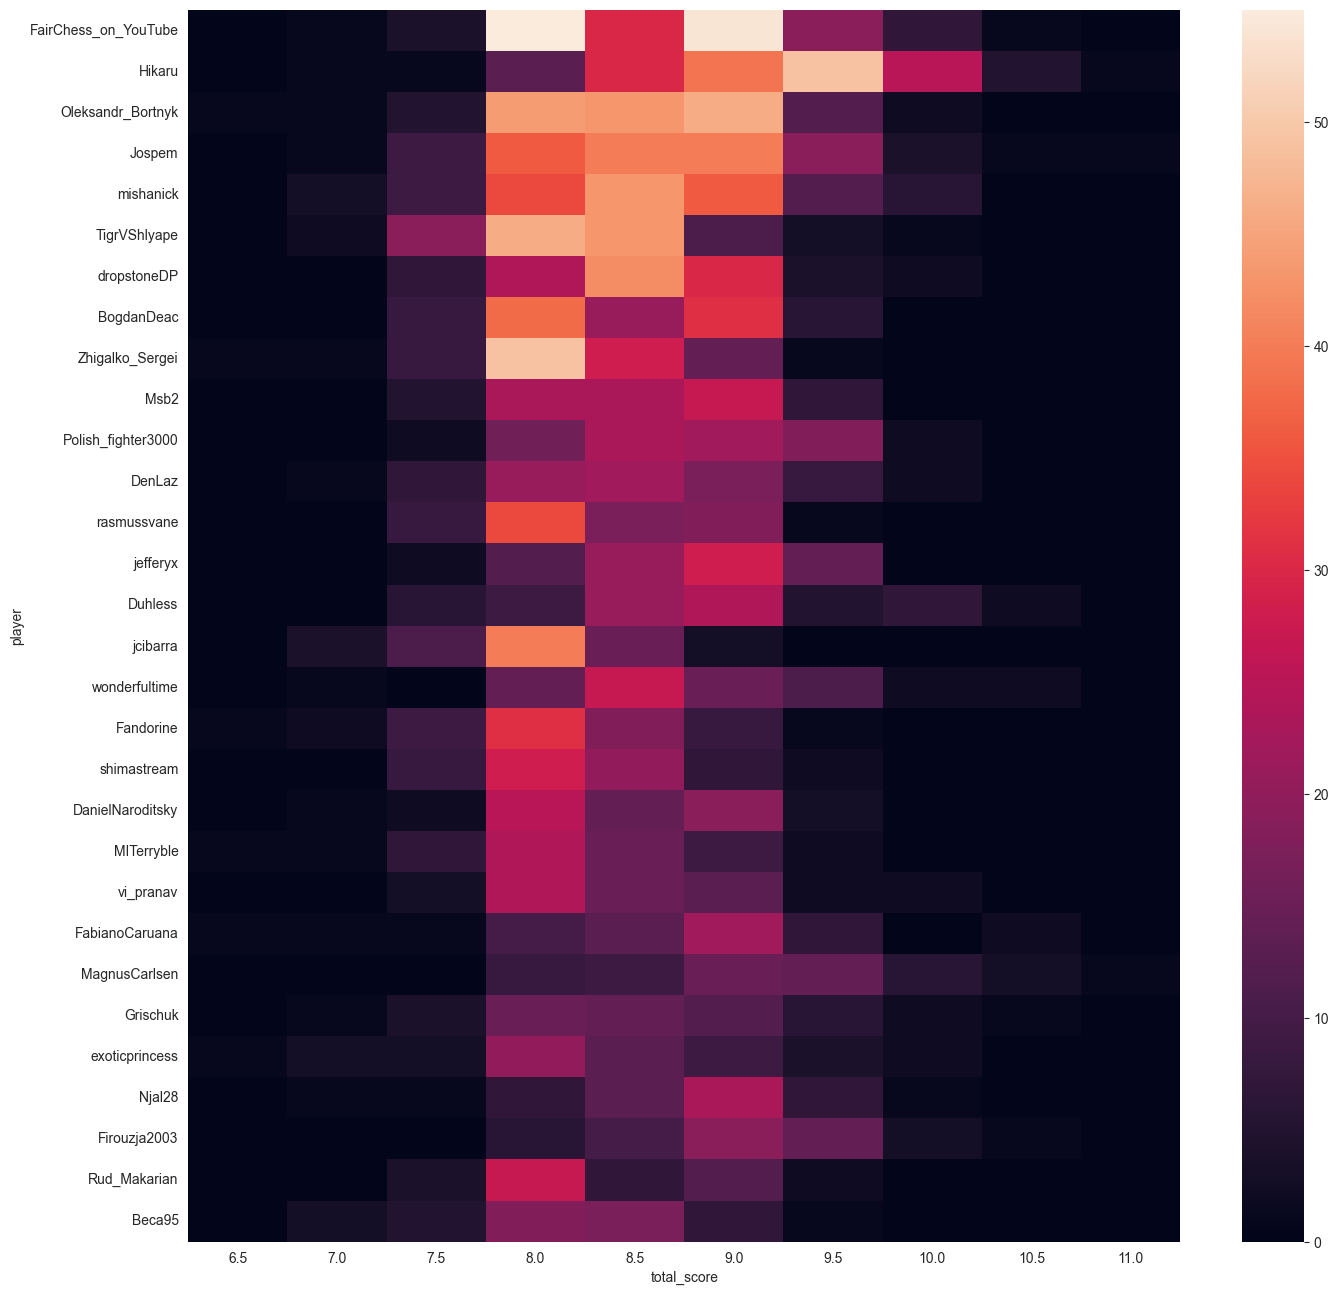

In [20]:
fig = plt.figure(figsize=(16,16))
sns.heatmap(players_df.drop(columns=['total_entries']).iloc[:,1:])

Как можно видеть, для некоторых игроков каждый второй турнир оканчивается попаданием в топ. При этом чаще всего они набирают около 8-9 очков - этого не всегда хватает для победы, но достаточно для внимания публики (топ-25 как раз отображается на первой странице с результатами).

In [21]:
players_avg = df.groupby('player').agg({'date':'nunique','total_score':'mean','rating':'mean'}).rename(columns={'date':'total_entries',
                                                                                                                'total_score':'avg_score',
                                                                                                                'rating':'avg_rating'})
players_avg = players_avg[players_avg.total_entries > 25]
players_avg = players_avg.sort_values('avg_score', ascending=False)

In [22]:
players_avg.head()

total_entries  avg_score  avg_rating
player                                             
Hikaru                   164   9.167683      3175.0
MagnusCarlsen             56   9.125000      3179.0
Firouzja2003              53   9.009434      3147.0
nihalsarin                43   8.906977      3218.0
HansOnTwitch              27   8.888889      3144.0

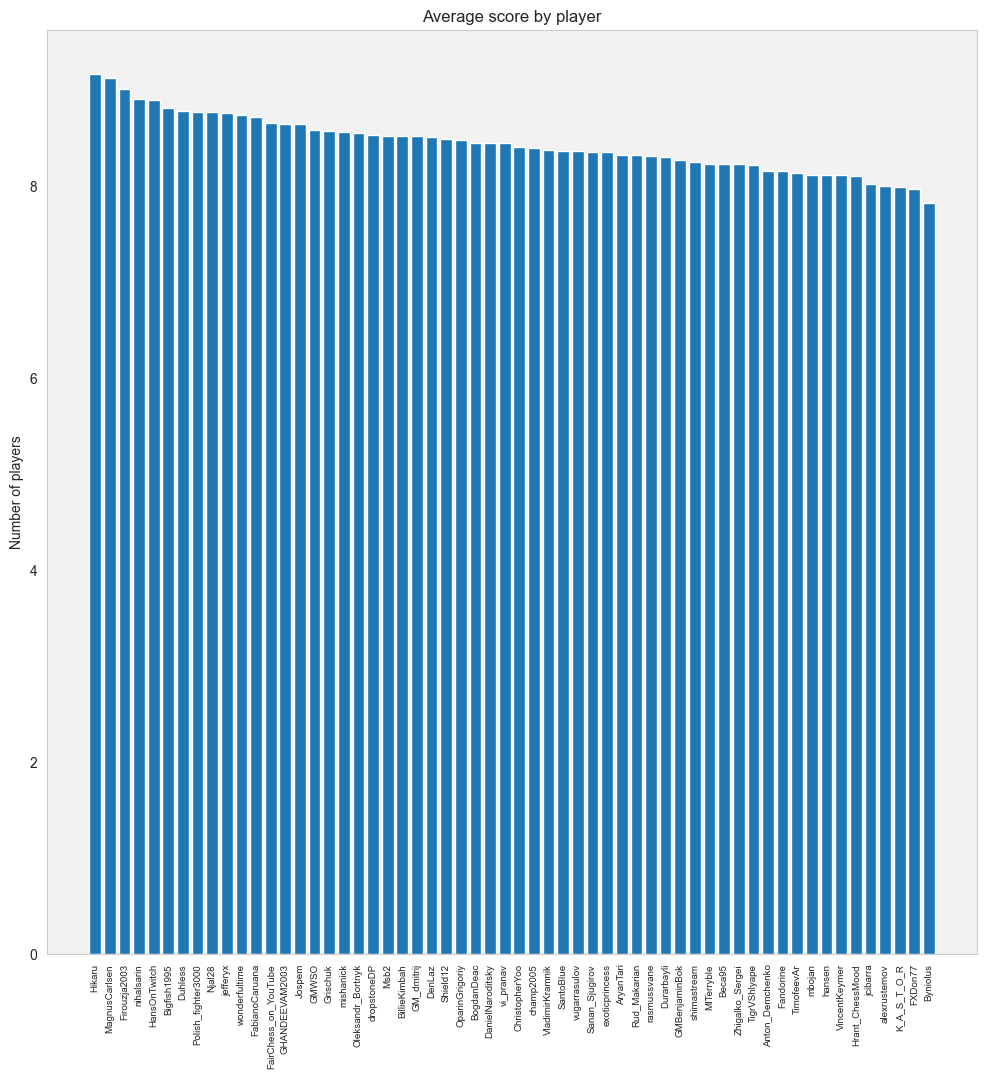

In [23]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.bar(players_avg.index, players_avg.avg_score)
ax.set_xticks(np.arange(0, len(players_avg)), list(players_avg.index), rotation=90, fontsize=7)
ax.set_title('Average score by player')
ax.set_ylabel('Number of players')
ax.grid(False)

<h2>Данные о лучших игроках: работа с графами</h2>

Получим данные о статистике игр лучших шахматистов между собой и построим на основе этих данных ориентированный граф, в котором ребра будут направлены от игрока, имеющего преимущество в парном противостоянии, к игроку, который в нем проигрывает.

In [24]:
best_players_df = pd.DataFrame()

for player in players_avg.index:
    opps_df = df[df.player == player].groupby('opponent').agg({'game_result' : 'sum'}).reset_index().rename(columns={'game_result':'games_no'})
    opps_df = opps_df.merge(players_avg, left_on='opponent', right_on='player').loc[:, ['opponent', 'games_no']].set_index('opponent').transpose()
    opps_df.index = [player]
    best_players_df = pd.concat([best_players_df, opps_df])
best_players_df = best_players_df.fillna(0)
best_players_df['total_score'] = best_players_df.sum(axis=1)
best_players_df = best_players_df.sort_values('total_score', ascending=False)
best_players_df.head()

opponent              Anton_Demchenko  AryanTari  Beca95  Bigfish1995  \
Hikaru                            5.0       10.0     8.0          7.0   
FairChess_on_YouTube              7.5        7.0     9.5          8.0   
Jospem                            4.5        4.0     7.5          6.5   
Oleksandr_Bortnyk                 6.0        0.0     2.5          3.0   
mishanick                         6.0        1.0     4.0          2.5   

opponent              BillieKimbah  BogdanDeac  Byniolus  ChristopherYoo  \
Hikaru                         5.0        12.0       2.0             2.0   
FairChess_on_YouTube           3.5         4.5       8.5             5.0   
Jospem                         4.0         4.5       8.0             5.5   
Oleksandr_Bortnyk              6.5         3.5       5.0             1.0   
mishanick                      2.0         9.0      10.0             3.5   

opponent              DanielNaroditsky  DenLaz  ...  mbojan  mishanick  \
Hikaru                             5.0     8.5  ...     8.0       20.5   
FairChess_on_YouTube               6.5     3.0  ...     6.5        7.5   
Jospem                             6.0     1.5  ...     6.5        2.5   
Oleksandr_Bortnyk                  4.5     0.5  ...     9.5        7.5   
mishanick                          2.5     4.0  ...     5.0        0.0   

opponent              nihalsarin  rasmussvane  shimastream  vi_pranav  \
Hikaru                       5.0         10.5          9.0        5.0   
FairChess_on_YouTube         3.0          5.5          4.5        3.0   
Jospem                       4.5          6.0          7.0        0.5   
Oleksandr_Bortnyk            4.5          5.5          4.5        3.0   
mishanick                    0.0          7.5          8.5        5.5   

opponent              vugarrasulov  wonderfultime  Hikaru  total_score  
Hikaru                         9.0           19.0     0.0        530.0  
FairChess_on_YouTube           6.0            4.5    13.0        376.0  
Jospem                         6.5            4.5     5.5        289.0  
Oleksandr_Bortnyk              4.0            3.0     8.5        275.0  
mishanick                      8.0            1.5     7.0        252.5  

[5 rows x 59 columns]

Сократим число рассматриваемых игроков до 15 в целях сохранения информативности итогового изображения (иначе граф будет слишком большим):

In [25]:
best_players_df = best_players_df.iloc[:15, :]
best_players_df = best_players_df.loc[:, best_players_df.index]
best_players_df['total_score'] = best_players_df.sum(axis=1)
best_players_df = best_players_df.sort_values('total_score', ascending=False)
best_players_df

Hikaru  FairChess_on_YouTube  Jospem  Oleksandr_Bortnyk  \
Hikaru                   0.0                  20.0    27.0               30.0   
FairChess_on_YouTube    13.0                   0.0    16.5               10.5   
Jospem                   5.5                  13.5     0.0                6.5   
Oleksandr_Bortnyk        8.5                  10.5     2.5                0.0   
MagnusCarlsen            8.5                   4.0     7.5               10.5   
mishanick                7.0                   8.0     8.5                4.5   
TigrVShlyape             5.0                   7.5     5.5                6.5   
Firouzja2003             7.0                   5.5     5.5                5.5   
jefferyx                 6.5                   8.5     3.0                3.0   
Duhless                  5.0                   4.0     5.0                7.5   
Msb2                     7.5                   5.5     4.0                9.0   
BogdanDeac               8.5                   7.5     1.5                4.5   
Polish_fighter3000       6.0                   2.0     4.0                2.5   
FabianoCaruana           8.0                   4.5     3.0                4.5   
dropstoneDP              3.5                   5.0     5.0                4.0   

                      mishanick  Duhless  MagnusCarlsen  TigrVShlyape  \
Hikaru                     20.5      9.0            8.5          14.5   
FairChess_on_YouTube        7.5      5.0            6.0          15.0   
Jospem                      2.5      3.5            6.5           8.0   
Oleksandr_Bortnyk           7.5      2.0            6.0          19.5   
MagnusCarlsen               5.5      4.5            0.0           4.5   
mishanick                   0.0      2.5            0.5          13.5   
TigrVShlyape                7.0      3.5            1.5           0.0   
Firouzja2003                7.0      3.0            4.0           5.5   
jefferyx                    4.5      5.5            0.5           9.0   
Duhless                     4.5      0.0            2.5           6.5   
Msb2                        2.5      2.0            3.0           4.0   
BogdanDeac                  4.0      3.0            0.0           9.0   
Polish_fighter3000          3.0      3.0            1.5           5.0   
FabianoCaruana              4.0      3.0            2.5           7.5   
dropstoneDP                 4.5      1.0            2.5           3.0   

                      Firouzja2003  Polish_fighter3000  jefferyx  dropstoneDP  \
Hikaru                         9.0                14.0      15.0         10.0   
FairChess_on_YouTube           3.5                 2.5       8.5         11.0   
Jospem                         9.0                 3.0       4.0          7.0   
Oleksandr_Bortnyk              1.5                 3.0       7.0          2.5   
MagnusCarlsen                  5.0                 6.5       5.5          2.5   
mishanick                      1.0                 2.0       3.5          6.5   
TigrVShlyape                   4.5                 2.0       5.0          5.5   
Firouzja2003                   0.0                 3.0       3.5          5.0   
jefferyx                       3.5                 1.5       0.0          3.0   
Duhless                        3.0                 1.0       3.5          5.0   
Msb2                           3.0                 2.0       0.5          2.5   
BogdanDeac                     1.5                 3.5       1.5          5.0   
Polish_fighter3000             6.0                 0.0       0.5          5.0   
FabianoCaruana                 2.0                 1.5       0.5          3.5   
dropstoneDP                    2.0                 3.0       4.0          0.0   

                      BogdanDeac  Msb2  FabianoCaruana  total_score  
Hikaru                      12.0  20.0             6.0        215.5  
FairChess_on_YouTube         4.5  11.0             2.5        117.0  
Jospem                       4.5   7.0           

Помимо направления ребер зададим их цвет: чем темнее ребро, тем больше процент набранных очков у лидирующего в противостоянии шахматиста.

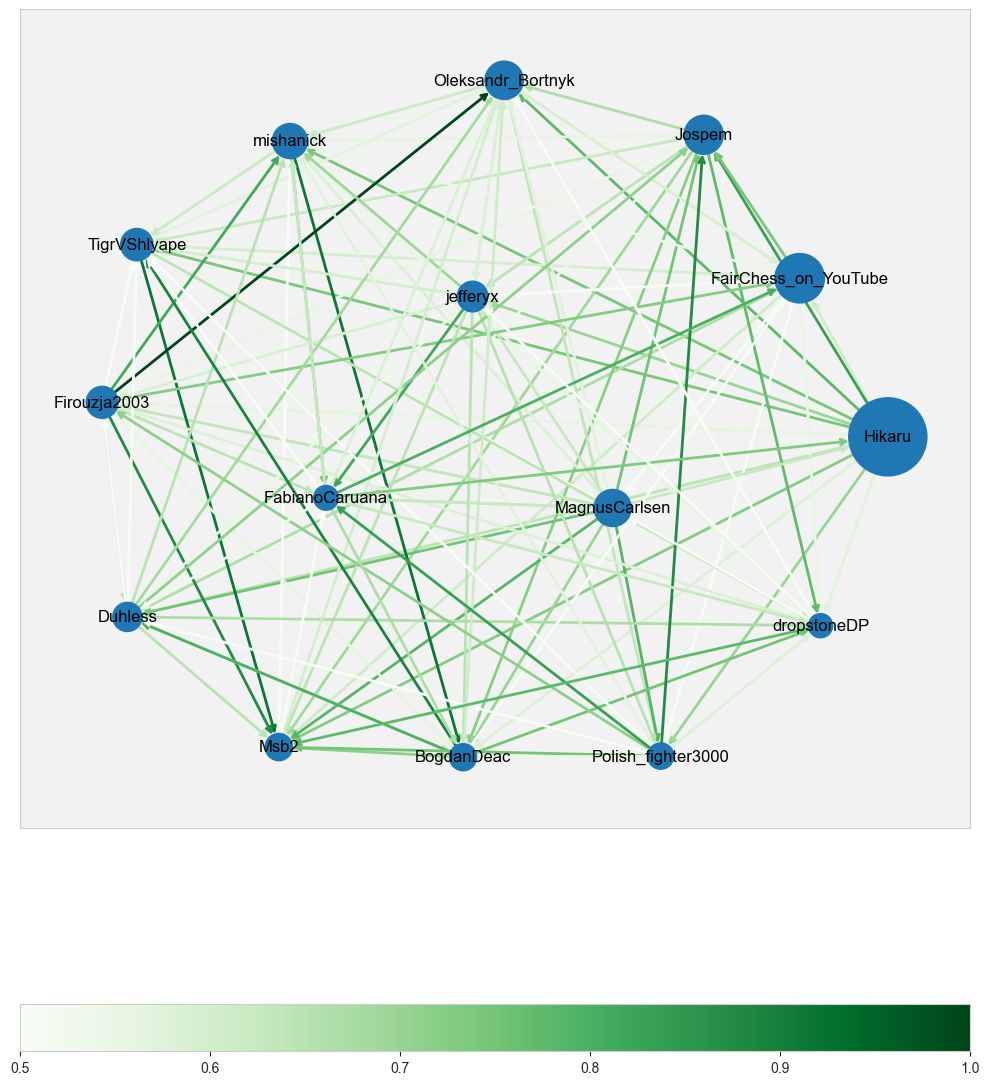

In [26]:
G = nx.DiGraph()
G.add_nodes_from(best_players_df.index)
edges = {}
for player1 in best_players_df.index:
    for player2 in best_players_df.index:
        if (best_players_df.loc[player1, player2] + best_players_df.loc[player2, player1] != 0):
            if best_players_df.loc[player1, player2] >= best_players_df.loc[player2, player1]:
                edges[(player1, player2)] = best_players_df.loc[player1, player2] / (best_players_df.loc[player1, player2] + best_players_df.loc[player2, player1])
            else:
                edges[(player2, player1)] = best_players_df.loc[player2, player1] / (best_players_df.loc[player1, player2] + best_players_df.loc[player2, player1])

edge_colors = []
for k,v in edges.items():
    G.add_edge(*k)
    edge_colors.append(v)
node_sizes = list(best_players_df.total_score ** 1.5)
cmap = plt.cm.Greens

fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(111)
pos = nx.kamada_kawai_layout(G)
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes,
                               arrowstyle="->", arrowsize=10,
                               edge_color=edge_colors, edge_cmap=cmap,
                               width=2)
labels = nx.draw_networkx_labels(G, pos)


pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc, ax=ax, location='bottom')
plt.grid(False) 
plt.tight_layout()
plt.show()


<h2><i>Работа с SQL</i></h2>

Создадм базу данных, в которой можно хранить наши данные.

In [4]:
engine = create_engine('sqlite:///chess_database.sqlite')
df.to_sql(name='chess', con=engine, if_exists='replace', index=0)

67716

In [5]:
%load_ext sql

In [6]:
%sql sqlite:///chess_database.sqlite

Извлечем информацию о пяти лучших игроках, представляющих Россию или Беларусь (на международных соревнованиях они играют под флагом Международной шахматной федерации):

In [30]:
%%sql
select player, avg(rating) as avg_rating 
from chess
group by player
having country == 'FIDE'
order by 2 desc
limit 5;

 * sqlite:///chess_database.sqlite
Done.


[('Grischuk', 3127.0),
 ('Duhless', 3114.0),
 ('DenLaz', 3095.0),
 ('lachesisQ', 3047.0),
 ('VladimirKramnik', 3019.0)]

Теперь узнаем, представители каких стран играют с представленными выше шахматистами лучше и хуже всего:

In [31]:
%%sql
with rus_bel_best as (select player, avg(rating) as avg_rating 
from chess
group by player
having country == 'FIDE'
order by 2 desc
limit 5) 

select country, avg(game_result) as points_percentage
from chess join rus_bel_best on chess.opponent = rus_bel_best.player
group by country
having count(*) > 5
order by 2 desc
limit 5;

 * sqlite:///chess_database.sqlite
Done.


[('Norway', 0.6666666666666666),
 ('Morocco', 0.6585365853658537),
 ('Barbados', 0.625),
 ('Armenia', 0.6022727272727273),
 ('Georgia', 0.5625)]

In [32]:
%%sql
with rus_bel_best as (select player, avg(rating) as avg_rating 
from chess
group by player
having country == 'FIDE'
order by 2 desc
limit 5) 

select country, avg(game_result) as points_percentage
from chess join rus_bel_best on chess.opponent = rus_bel_best.player
group by country
having count(*) > 5
order by 2
limit 5;

 * sqlite:///chess_database.sqlite
Done.


[('Kazakhstan', 0.07142857142857142),
 ('Peru', 0.36363636363636365),
 ('Spain', 0.38461538461538464),
 ('International', 0.3854166666666667),
 ('Netherlands', 0.3888888888888889)]

Помимо ожидаемых Норвегии и Марокко (их на сайте представляют лучшие шахматисты мира), в топе стран расположились Армения и Грузия (сказывается понимание принципов советской школы шахмат). Хуже всего против топ-шахматистов России выступают казахстанские игроки (вероятно, совсем забывшие о советской школе :(...), а также представители Перу, Испании, Нидерландов и игроки, предпочитающие не указывать страну (среди них также может быть много российских/белорусских шахматистов). 

<h2>Получение данных. Работа с REST API</h2>

Воспользуемся API chess.com для сбора данных о рейтинге игроков, рассчитываемом международной федерацией шахмат.

In [7]:
players = pd.read_sql('''select player, avg(rating) as avg_rating
from chess 
group by player 
order by 2 desc
limit 222
''', engine)

In [8]:
players 

player  avg_rating
0          nihalsarin      3218.0
1      FabianoCaruana      3205.0
2       MagnusCarlsen      3179.0
3              Hikaru      3175.0
4    ChessWarrior7197      3150.0
..                ...         ...
217         mitrabhaa      2898.0
218       anon6121824      2898.0
219      Semen_Khanin      2898.0
220        Radzio1987      2898.0
221    LionTheLeon_06      2898.0

[222 rows x 2 columns]

In [8]:
from chessdotcom.aio import get_player_stats, Client, RateLimitHandler
Client.aio = True
Client.rate_limit_handler.tries = 5
Client.rate_limit_handler.tts = 5

usernames = players.player
cors = [get_player_stats(name) for name in usernames]
    
async def gather_cors(cors):
   responses = await asyncio.gather(*cors)
   return [response.json['stats'].get('fide', '-') for response in responses]

In [9]:
players['rating_FIDE'] = await gather_cors(cors)
players = players.rename(columns={'avg_rating':'rating_chess_com'})

In [10]:
players['rating_FIDE'] = pd.to_numeric(players['rating_FIDE'], errors='coerce')

In [11]:
players

player  rating_chess_com  rating_FIDE
0          nihalsarin            3218.0       2620.0
1      FabianoCaruana            3205.0       2835.0
2       MagnusCarlsen            3179.0       2882.0
3              Hikaru            3175.0       2814.0
4    ChessWarrior7197            3150.0          NaN
..                ...               ...          ...
217         mitrabhaa            2898.0          NaN
218       anon6121824            2898.0       2470.0
219      Semen_Khanin            2898.0       2575.0
220        Radzio1987            2898.0       2733.0
221    LionTheLeon_06            2898.0       2558.0

[222 rows x 3 columns]

Очистим данные от пропущенных значений и добавим к ним статистику по проценту побед, игр белыми/черными фигурами, стране и результатам тай-брейка:

In [12]:
players = players[players.rating_FIDE.notna() & players.rating_FIDE > 0]
agg_df = df.groupby(['player']).agg({'game_result' : 'mean',
                                     'tie_break' : 'mean',
                                     'pieces_color' : lambda x: sum([1 if x.iloc[i]=='w' else 0 for i in range(len(x))])/
                                     len([1 if x.iloc[i]=='w' else 0 for i in range(len(x))]),
                                     'total_score' : 'mean',
                                     'date': 'nunique'}).rename(columns={'date' : 'tournaments_no', 'pieces_color': 'white_percentage'}).reset_index()
country_player = pd.read_sql('''select player, country
from chess 
group by player 
''', engine)
agg_df = agg_df.merge(country_player) 
agg_df = agg_df.merge(players)
agg_df = agg_df[agg_df.tournaments_no >= 3]
agg_df

player  game_result  tie_break  white_percentage  \
0    Alexander_Donchenko     0.761364  57.229167          0.530303   
2     AlmasRakhmatullaev     0.772727  67.666667          0.484848   
3              Andreikka     0.784091  61.541667          0.500000   
4         AnishOnYoutube     0.809091  72.800000          0.472727   
5     Antipov_Mikhail_Al     0.736364  63.450000          0.490909   
..                   ...          ...        ...               ...   
130             viviania     0.803030  64.333333          0.484848   
131         vugarrasulov     0.760331  65.727273          0.515152   
132        wonderfultime     0.794192  63.468750          0.516414   
133            xamax2000     0.772727  70.333333          0.484848   
134          yosephtaher     0.772727  71.125000          0.454545   

     total_score  tournaments_no        country  rating_chess_com  rating_FIDE  
0       8.375000              12  International            2913.0       2684.0  
2       8.500000               3     Uzbekistan            2915.0       2426.0  
3       8.625000              12           FIDE            3004.0       2683.0  
4       8.900000               5    Netherlands            3056.0       2764.0  
5       8.100000               5  United States            2930.0       2673.0  
..           ...             ...            ...               ...          ...  
130     8.833333               3        Ukraine            2904.0       2678.0  
131     8.363636              33     Azerbaijan            2999.0       2511.0  
132     8.736111              72        Vietnam            3015.0       2542.0  
133     8.500000               3    Netherlands            2942.0       2535.0  
134     8.500000               4      Indonesia            2917.0       2455.0  

[100 rows x 9 columns]

После обработки данных у нас имеются сведения о выступлениях и результатах 100 игроков. Попробуем выявить некоторые закономерности, применив продвинутый метод под названием "анализ графиков". 

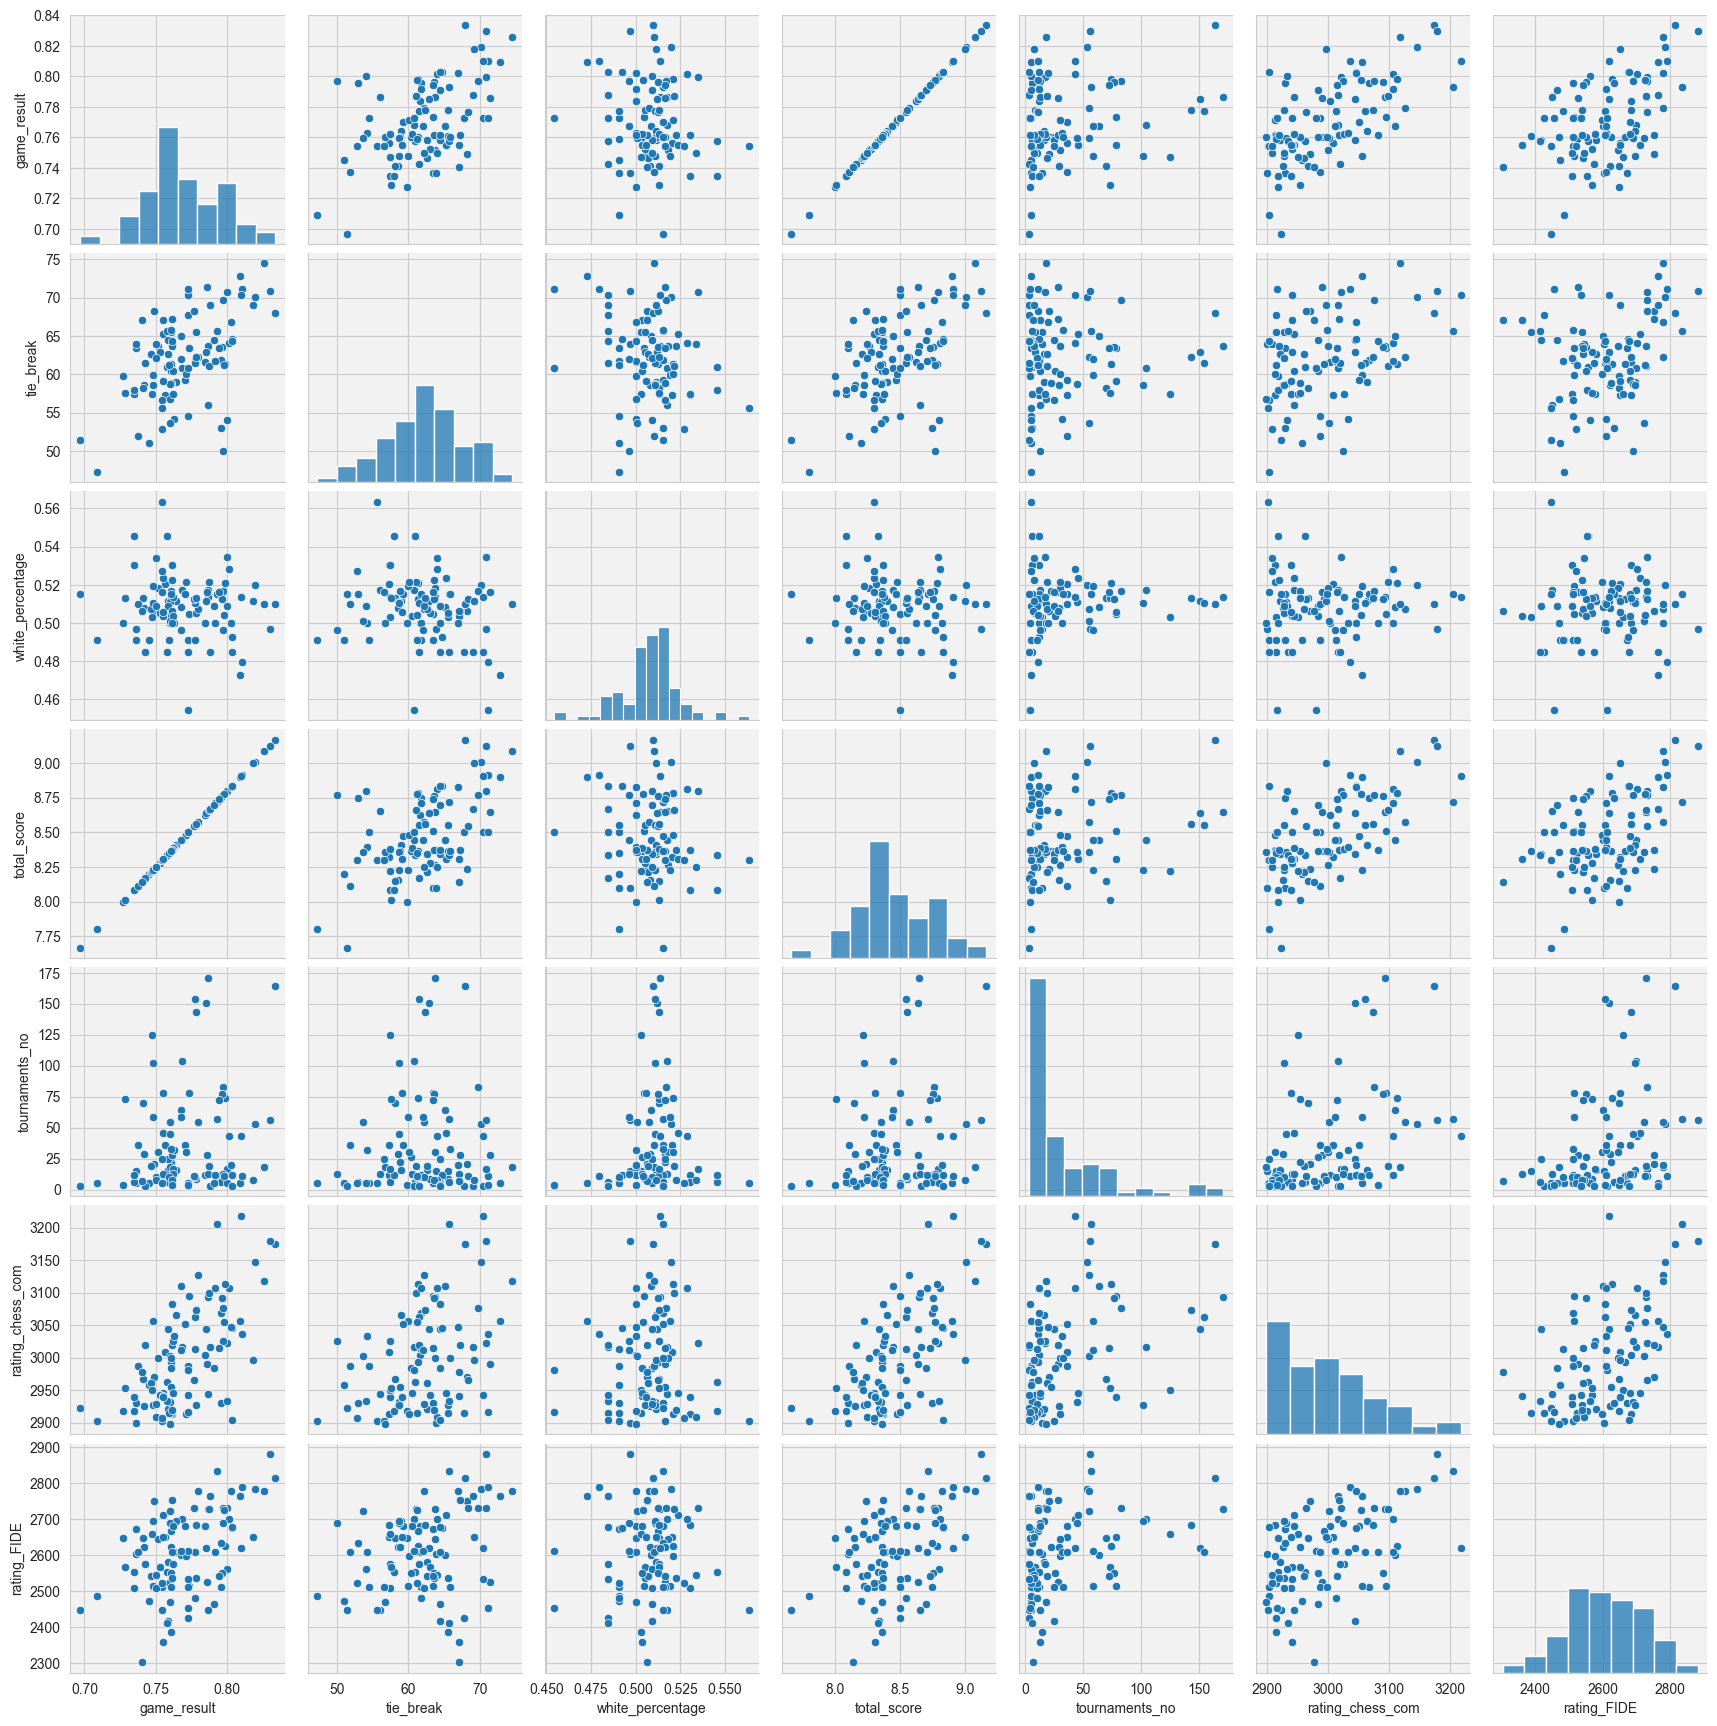

In [41]:
agg_df_num = agg_df.loc[:, ['game_result', 'tie_break', 'white_percentage', 
                            'total_score', 'tournaments_no', 'rating_chess_com', 'rating_FIDE']]
sns.pairplot(agg_df_num)

К сожалению, при больших объемах наблюдений и переменных разобраться в происходящем очень непросто, поэтому придется обратиться к более эффективным решениям.

<h2>Машинное обучение и статистика</h2>

На помощь придет машинное обучение: построим линейную регрессию со всеми количественными переменными, извлеченными в предыдущем пункте:

In [13]:
X, y = agg_df.loc[:, ['tie_break', 'white_percentage',
                      'tournaments_no',	'rating_chess_com',	'rating_FIDE']], agg_df.total_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

In [17]:
lin_reg.coef_

array([ 0.01781427, -0.13383677, -0.00081967,  0.00117531,  0.00067891])

In [18]:
print('Metrics for linear regression:')
print("R-squared: %.5f" % r2_score(y_test, y_pred))
print("Mean absolute error: %.5f" % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.5f" % mean_squared_error(y_test, y_pred))
print("Median absolute error: %.5f" % median_absolute_error(y_test, y_pred))

Metrics for linear regression:
R-squared: 0.50483
Mean absolute error: 0.18225
Mean squared error: 0.04929
Median absolute error: 0.16584


Неплохой результат, который тем не менее можно улучшить с помощью DecisionTreeRegressor. Параметры будем подбирать на основании нескольких метрик, чтобы сравнить результаты:

In [19]:
X, y = agg_df.loc[:, ['tie_break', 'white_percentage',
                      'tournaments_no',	'rating_chess_com',	'rating_FIDE']], agg_df.total_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

dt_reg = DecisionTreeRegressor(random_state=42)
params = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
          'max_depth' : range(1,6),
          'min_samples_split' : range(10,21),
          'min_samples_leaf' : range(1,7)}
clf = GridSearchCV(dt_reg, params, scoring='neg_mean_squared_error', verbose=3)

In [20]:
clf.fit(X_train, y_train)
clf_best = clf.best_estimator_
y_pred = clf_best.predict(X_test)

Fitting 5 folds for each of 1320 candidates, totalling 6600 fits
[CV 1/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=10;, score=-0.078 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=10;, score=-0.066 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=10;, score=-0.054 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=10;, score=-0.066 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=10;, score=-0.035 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=11;, score=-0.078 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=11;, score=-0.066 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=1, mi

In [21]:
clf_best.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [22]:
clf_best.feature_importances_

array([0.3841902, 0.       , 0.       , 0.6158098, 0.       ])

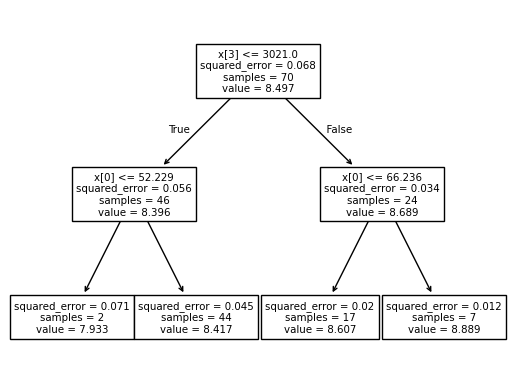

In [23]:
plot_tree(clf_best)
plt.show()

In [24]:
print('Metrics for decision tree regression:')
print("R-squared: %.5f" % r2_score(y_test, y_pred))
print("Mean absolute error: %.5f" % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.5f" % mean_squared_error(y_test, y_pred))
print("Median absolute error: %.5f" % median_absolute_error(y_test, y_pred))

Metrics for decision tree regression:
R-squared: 0.57691
Mean absolute error: 0.17892
Mean squared error: 0.04212
Median absolute error: 0.16491


In [34]:
X, y = agg_df.loc[:, ['tie_break', 'white_percentage',
                      'tournaments_no',	'rating_chess_com',	'rating_FIDE']], agg_df.total_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

dt_reg = DecisionTreeRegressor(random_state=42)
params = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
          'max_depth' : range(1,6),
          'min_samples_split' : range(5,16),
          'min_samples_leaf' : range(1,7)}
clf = GridSearchCV(dt_reg, params, scoring='r2', verbose=3)

In [35]:
clf.fit(X_train, y_train)
clf_best = clf.best_estimator_
y_pred = clf_best.predict(X_test)

Fitting 5 folds for each of 1320 candidates, totalling 6600 fits
[CV 1/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=5;, score=0.102 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=5;, score=-0.100 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=5;, score=0.248 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=5;, score=-0.391 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=5;, score=0.232 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=6;, score=0.102 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=1, min_samples_leaf=1, min_samples_split=6;, score=-0.100 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=1, min_samples_l

In [36]:
clf_best.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [37]:
clf_best.feature_importances_

array([0.30284082, 0.        , 0.14641026, 0.48541671, 0.06533221])

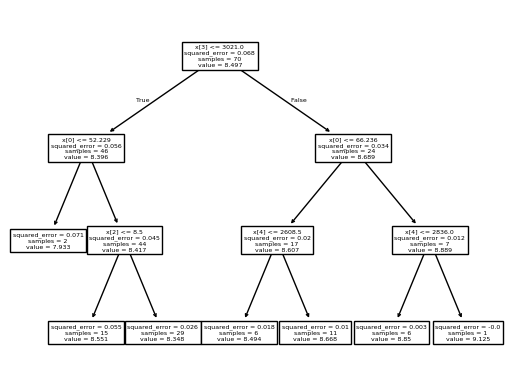

In [38]:
plot_tree(clf_best)
plt.show()

In [39]:
print('Metrics for decision tree regression:')
print("R-squared: %.5f" % r2_score(y_test, y_pred))
print("Mean absolute error: %.5f" % mean_absolute_error(y_test, y_pred))
print("Mean squared error: %.5f" % mean_squared_error(y_test, y_pred))
print("Median absolute error: %.5f" % median_absolute_error(y_test, y_pred))

Metrics for decision tree regression:
R-squared: 0.40118
Mean absolute error: 0.20301
Mean squared error: 0.05961
Median absolute error: 0.20992


Согласно всем деревьм, лучше всего итог предсказывается по рейтингу на chess.com (даже лучше, чем по рейтингу FIDE!!!)

А можно результат улучшить еще больше?

In [26]:
cbr = CatBoostRegressor()
params = {'depth':[2,3],
          'learning_rate' : [.1,.2,.25,.275,.3,.325,.35,.375,.4,.5,.6],
          'l2_leaf_reg': [1,2,3],
          'iterations': [100, 200]}

clf_cbr = cbr.grid_search(params,
            X,
            y,
            cv=5,
            partition_random_seed=42,
            train_size=0.7,
            plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.6861237	test: 7.6304350	best: 7.6304350 (0)	total: 614us	remaining: 60.9ms
1:	learn: 6.9495288	test: 6.9018916	best: 6.9018916 (1)	total: 1.45ms	remaining: 70.8ms
2:	learn: 6.2910351	test: 6.2507221	best: 6.2507221 (2)	total: 1.91ms	remaining: 61.7ms
3:	learn: 5.6876629	test: 5.6486458	best: 5.6486458 (3)	total: 2.33ms	remaining: 56ms
4:	learn: 5.1422095	test: 5.1096137	best: 5.1096137 (4)	total: 2.72ms	remaining: 51.7ms
5:	learn: 4.6486928	test: 4.6145548	best: 4.6145548 (5)	total: 3.07ms	remaining: 48.1ms
6:	learn: 4.2021661	test: 4.1627052	best: 4.1627052 (6)	total: 3.4ms	remaining: 45.2ms
7:	learn: 3.8008350	test: 3.7636689	best: 3.7636689 (7)	total: 3.74ms	remaining: 43ms
8:	learn: 3.4381022	test: 3.3995608	best: 3.3995608 (8)	total: 4.16ms	remaining: 42ms
9:	learn: 3.1101049	test: 3.0886744	best: 3.0886744 (9)	total: 4.64ms	remaining: 41.8ms
10:	learn: 2.8138548	test: 2.7927097	best: 2.7927097 (10)	total: 4.99ms	remaining: 40.4ms
11:	learn: 2.5500827	test: 2.5284906	b

In [27]:
clf_cbr['params']

{'depth': 2, 'learning_rate': 0.325, 'l2_leaf_reg': 1, 'iterations': 100}

нет...